In [1]:
"""
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download alessiocorrado99/animals10
! unzip animals10.zip
"""

'\n! mkdir ~/.kaggle\n! cp kaggle.json ~/.kaggle/\n! chmod 600 ~/.kaggle/kaggle.json\n! kaggle datasets download alessiocorrado99/animals10\n! unzip animals10.zip\n'

Importing librairies

In [2]:
import tensorflow as tf
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, accuracy_score

Accessing the files and creating a dataframe with the image id and the name of the animal associated

In [3]:
directory = '/content/raw-img'
name = []
img_id = []

for dirname, _, filenames in os.walk(directory):
    for filename in filenames:
        img_id.append(os.path.join(os.path.basename(dirname),filename))
        name.append(os.path.basename(dirname))

df = pd.DataFrame({"img_id":img_id, "name":name})
df.head()

,img_id,name
0,cane/OIP-VzubOr7Fzau8e31_GWHtcQHaJj.jpeg,cane
1,cane/OIP-tYYHNtfEzdyMNboNmYeD3wHaD4.jpeg,cane
2,cane/OIP-LBk61xKG1utMLyGyu0rnnQHaE7.jpeg,cane
3,cane/OIP-UEeHsUBwqcq03WdGXW1ZKQHaFj.jpeg,cane
4,cane/OIP-IqnVr8rt1l74QRbp1eXf6wHaHA.jpeg,cane


Visualising the data distribution

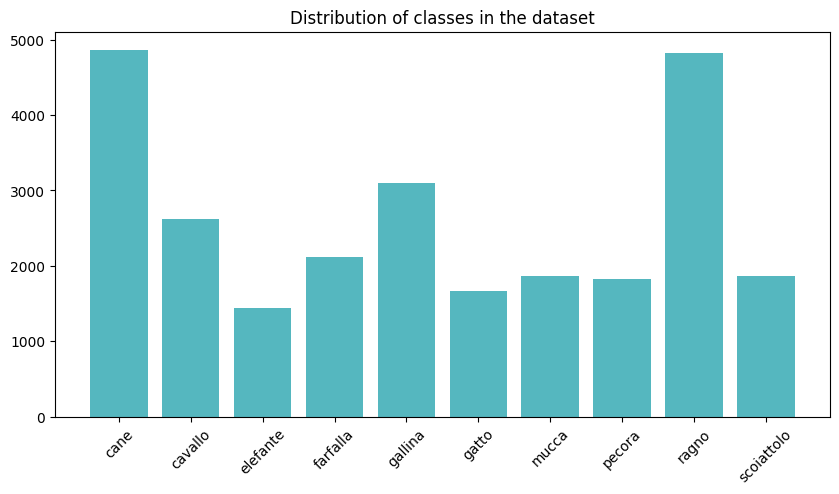

In [9]:
classes, counts = np.unique(df["name"], return_counts=True)

plt.figure(figsize=(10,5))
plt.bar(classes,counts,color="#55B7BF")
plt.xticks(rotation=45)
plt.title("Distribution of classes in the dataset")
plt.show()

Generating a training and testing set.

In [10]:
df_train, df_test = train_test_split(df,test_size = 0.2)
print("Shape of training set",df_train.shape)
print("Shape of testing set",df_test.shape)

Shape of training set (20943, 2)
Shape of testing set (5236, 2)


Generating normalised and randomly augmented images from the original images, with a training and validation set.

In [6]:
batch_size = 64
img_size = (224,224)

train_datagen = ImageDataGenerator(
    shear_range=0.2,
    rotation_range=180,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2)

test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_dataframe(
    directory=directory,
    dataframe=df_train,
    x_col = "img_id",
    y_col = "name",
    shuffle = True,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset="training")

val_generator = train_datagen.flow_from_dataframe(
    directory=directory,
    dataframe=df_train,
    x_col = "img_id",
    y_col = "name",
    shuffle = True,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset="validation")

test_generator = test_datagen.flow_from_dataframe(
    directory=directory,
    dataframe=df_test,
    x_col = "img_id",
    y_col = "name",
    target_size=img_size,
    batch_size=batch_size,
    shuffle = False,
    class_mode="categorical")

Found 16755 validated image filenames belonging to 10 classes.
Found 4188 validated image filenames belonging to 10 classes.
Found 5236 validated image filenames belonging to 10 classes.


Creating arrays with some of the images generated.

In [7]:
num_batches = 5

images = []
labels = []

for i in range(num_batches):
    batch_data, batch_labels = train_generator.next()
    batch_data /= 255
    images.append(batch_data)

    labels.extend(np.argmax(batch_labels, axis=1))

images = np.concatenate(images, axis=0)

labels = np.array(labels)

Displaying some of the images present in the dataset, except for the spiders pictures.

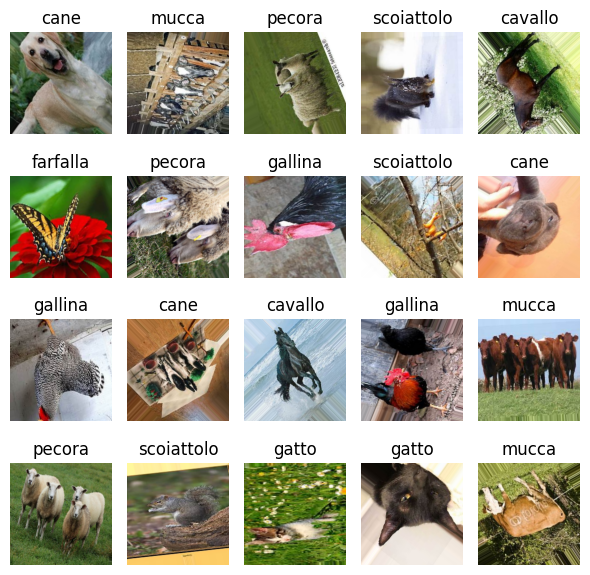

In [8]:
n_rows = 4
n_cols = 5

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6, 6))

for i in range(n_rows):
    for j in range(n_cols):
        r = random.randint(0, len(labels) - 1)

        while labels[r] == 8:
            r = random.randint(0, len(labels) - 1)

        axes[i, j].imshow(images[r])
        axes[i, j].set_title(classes[labels[r]])
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()

Creating a model using EfficientnetB3

In [12]:
img_shape = img_size + tuple([3])

efficient_net = EfficientNetV2B2(
    weights='imagenet',
    input_shape=img_shape,
    include_top=False,
    pooling='max')

model = Sequential()
model.add(efficient_net)
model.add(layers.Dense(1024,activation="relu"))
#model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))
model.summary()

35839040/35839040 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b2 (Functio  (None, 1408)              8769374   
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1024)              1442816   
                                                                 
 dense_1 (Dense)             (None, 10)                10250     
                                                                 
Total params: 10222440 (39.00 MB)
Trainable params: 10140152 (38.68 MB)
Non-trainable params: 82288 (321.44 KB)
_________________________________________________________________


In [13]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["categorical_accuracy"])
early_stopping = EarlyStopping(monitor="val_categorical_accuracy",patience=2,restore_best_weights=True)

In [14]:
nb_epochs = 10
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = val_generator,
    validation_steps = val_generator.samples // batch_size,
    epochs = nb_epochs,
    callbacks=[early_stopping])

Epoch 1/10
261/261 [==============================] - 429s 1s/step - loss: 0.9157 - categorical_accuracy: 0.8077 - val_loss: 0.2498 - val_categorical_accuracy: 0.9224
Epoch 2/10
261/261 [==============================] - 366s 1s/step - loss: 0.3270 - categorical_accuracy: 0.8942 - val_loss: 0.2406 - val_categorical_accuracy: 0.9255
Epoch 3/10
261/261 [==============================] - 346s 1s/step - loss: 0.2781 - categorical_accuracy: 0.9104 - val_loss: 0.2184 - val_categorical_accuracy: 0.9351
Epoch 4/10
261/261 [==============================] - 380s 1s/step - loss: 0.2519 - categorical_accuracy: 0.9194 - val_loss: 0.2293 - val_categorical_accuracy: 0.9308
Epoch 5/10
261/261 [==============================] - 352s 1s/step - loss: 0.2400 - categorical_accuracy: 0.9222 - val_loss: 0.2135 - val_categorical_accuracy: 0.9298


Plotting the loss and accuracy

In [16]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
cat_accuracy = history.history["categorical_accuracy"]
val_cat_accuracy = history.history["val_categorical_accuracy"]
x = np.arange(len(loss))

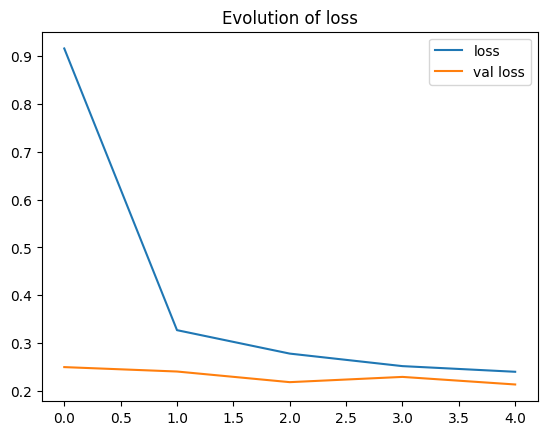

In [17]:
plt.plot(x,loss,label="loss")
plt.plot(x,val_loss,label="val loss")
plt.legend()
plt.title("Evolution of loss")
plt.show()

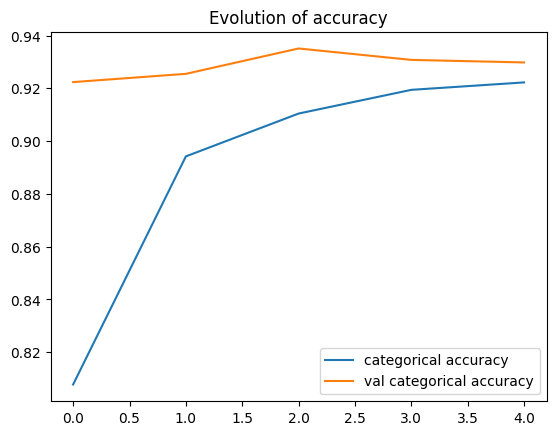

In [18]:
plt.plot(x,cat_accuracy,label="categorical accuracy")
plt.plot(x,val_cat_accuracy,label="val categorical accuracy")
plt.legend()
plt.title("Evolution of accuracy")
plt.show()

Evaluating the model

In [19]:
model.evaluate(test_generator)

82/82 [==============================] - 15s 186ms/step - loss: 0.2253 - categorical_accuracy: 0.9332


[0.22530125081539154, 0.9331550598144531]

Visualising the confusion matrix

In [20]:
preds_raw = model.predict(test_generator)
preds = np.argmax(preds_raw, axis=1)

82/82 [==============================] - 22s 240ms/step


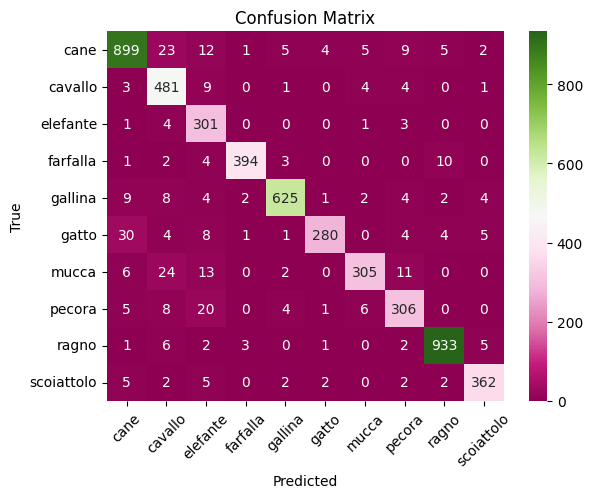

In [21]:
cm = confusion_matrix(test_generator.classes,preds)

sns.heatmap(cm, annot=True, fmt="d", cmap="PiYG", xticklabels=classes, yticklabels=classes)

plt.xlabel('Predicted')
plt.xticks(rotation=45)
plt.ylabel('True')
plt.title('Confusion Matrix')

plt.show()

Saving the model

In [22]:
from google.colab import drive
model.save("animals10_classification_v0")
drive.mount('/content/drive')
!cp -r "animals10_classification_v0" "/content/drive/MyDrive/"

Mounted at /content/drive


Checking some random images and their predicted names.

In [23]:
N = 500
images = []
names = []
for i in range(N):
    r = random.randint(0,len(df)-1)
    img = cv2.imread(directory+"/"+df["img_id"][r])
    images.append(img)
    names.append(df["name"][r])

1/1 [==============================] - 0s 47ms/step


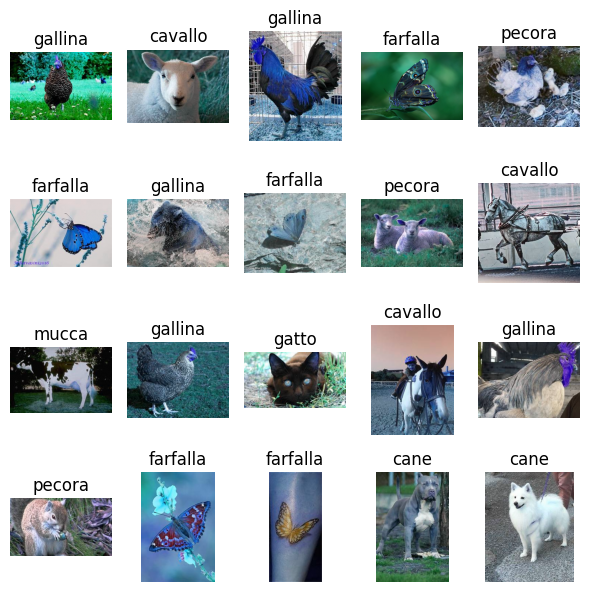

In [28]:
n_rows = 4
n_cols = 5

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6, 6))

for i in range(n_rows):
    for j in range(n_cols):

        r = random.randint(0, len(names) - 1)

        while names[r] == "ragno":
            r = random.randint(0, len(names) - 1)


        img = cv2.resize(images[r],(224,224))
        img = np.expand_dims(img, axis=0)
        name_pred = np.argmax(model.predict(img))



        axes[i, j].imshow(images[r]/255)
        axes[i, j].set_title(classes[name_pred])
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()